In [8]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl"

import json
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image, ImageEnhance
from typing import Optional

import trimesh
import pyrender
from pyrender.constants import RenderFlags
from tqdm.notebook import tqdm
import maxflow
import time

## Utils

In [2]:
import cv2
import numpy as np

def compute_pose(img: np.ndarray):
    # Get the size of the input image
    img_size = img.shape[:2]
    
    # Convert the image to grayscale, as marker detection typically works better in grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect markers in the grayscale image
    img_corners, img_ids, rejected_corners = detector.detectMarkers(gray)
    
    # Refine the detected markers to improve accuracy
    img_corners, img_ids, rejected_corners, recovered_ids = detector.refineDetectedMarkers(
        img,
        board,
        img_corners,
        img_ids,
        rejected_corners
    )
    
    # Match object points (3D) and image points (2D) based on detected markers for pose estimation
    obj_points, img_points = board.matchImagePoints(img_corners, img_ids)
    
    # Estimate the initial pose using solvePnP with matched points
    retval, rvec, tvec = cv2.solvePnP(
        obj_points,
        img_points,
        cameraMatrix,
        distCoeffs
    )

    # Refine the initial pose estimation using the Levenberg-Marquardt optimization
    # This optimizes `rvec` and `tvec` for a more accurate pose.
    rvec, tvec = cv2.solvePnPRefineLM(
        obj_points,
        img_points,
        cameraMatrix,
        distCoeffs,
        rvec,
        tvec
    )
    
    # Convert the rotation vector `rvec` to a rotation matrix `R_oc`
    R_oc, _ = cv2.Rodrigues(rvec)
    
    # Transform rotation from object to camera coordinates to world coordinates
    R_wc = T @ R_oc.T
    
    # Calculate the world coordinates translation vector `t_wc`
    t_wc = -R_wc @ tvec
    
    # Return the rotation matrix, translation vector, rotation vector, and translation vector
    return R_wc, t_wc, rvec, tvec

def rgb_to_hex(rgb):
    # Convert an RGB color tuple to a HEX color string
    return '#{:02X}{:02X}{:02X}'.format(*rgb)


## Scene Generation

In [3]:
# Function to normalize a vector
def norm(v: np.ndarray) -> np.ndarray:
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

# Scene class to handle 3D scene rendering, camera setup, and sample image generation
class Scene:
    def __init__(self, mesh, image_width: int = 640, image_height: int = 480) -> None:
        # Initialize image dimensions
        self.image_width = image_width
        self.image_height = image_height

        # Load mesh object and set pose (translated down on Y-axis)
        naruto_mesh = pyrender.Mesh.from_trimesh(mesh)
        naruto_pose = np.eye(4)
        naruto_pose[1, 3] = -1

        # Create pyrender scene with ambient lighting    
        self.pyrender_scene = pyrender.Scene(ambient_light=[0.5, 0.5, 0.5])
        self.pyrender_scene.add(naruto_mesh, pose=naruto_pose)
        
        # Set up the renderer and camera
        self.renderer = pyrender.OffscreenRenderer(image_width, image_height)
        camera = pyrender.PerspectiveCamera(yfov = np.pi / 3.0, aspectRatio=1.0)
        self.camera_node = pyrender.Node(camera=camera)
        self.pyrender_scene.add_node(self.camera_node)

        # Initialize point cloud list
        self.point_clouds = []

        # Transformation matrix to flip Y and Z axes
        self.T = np.array([
            [1, 0, 0],
            [0, -1, 0],
            [0, 0, -1]
        ])
        
    # Method to add points to the scene with specified radius and color
    def add_points(self, points: np.ndarray, radius: float = 0.01, color: list[float] = [0, 0, 0.5]) -> None:
        sm = trimesh.creation.uv_sphere(radius=radius)
        sm.visual.vertex_colors = color
        tfs = np.tile(np.eye(4), (len(points), 1, 1))
        tfs[:,:3,3] = points
        pts = pyrender.Mesh.from_trimesh(sm, poses=tfs)
        node = self.pyrender_scene.add(pts)
        self.point_clouds.append(node)

    # Method to remove all points added to the scene
    def remove_all_points(self) -> None:
        for ptsc in self.point_clouds:
            self.pyrender_scene.remove_node(ptsc)
        self.point_clouds = []

    # Method to sample a view with rotation angles for the camera      
    def sample(self, alpha: Optional[float] = None, beta: Optional[float] = None, gamma: Optional[float] = None, return_depth: bool = False) -> [Image.Image, np.ndarray, np.ndarray]:
        # Generate random rotation angles if none are provided
        rand = np.random.uniform(0, 360, (3)) * np.pi / 180
        if alpha == None:
            alpha = rand[0]
        else:
            alpha *= np.pi / 180
        if beta == None:
            beta = rand[1]
        else:
            beta *= np.pi / 180
        if gamma ==  None:
            gamma = rand[2]
        else:
            gamma *= np.pi / 180

        # Define rotation matrices for X, Y, Z axes
        Rx = np.array([
                            [1, 0, 0, 0],
                            [0, np.cos(alpha), -np.sin(alpha), 0],
                            [0, np.sin(alpha), np.cos(alpha), 0],
                            [0, 0, 0, 1]]
                        )
        Ry = np.array([
                            [np.cos(beta), 0, np.sin(beta), 0],
                            [0, 1, 0, 0],
                            [-np.sin(beta), 0, np.cos(beta), 0],
                            [0, 0, 0, 1]]
                        )
        Rz = np.array([
                            [np.cos(gamma), -np.sin(gamma), 0, 0],
                            [np.sin(gamma), np.cos(gamma), 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]]
                        )
        
        # Camera pose based on combined rotations and translation along Z-axis
        camera_pose = Rx @ Ry @ Rz @ np.array([
                            [1, 0, 0, 0],
                            [0, 1, 0, 0],
                            [0, 0, 1, 2],
                            [0, 0, 0, 1]]
                        )
        
        # Render the scene to obtain color and depth images
        self.pyrender_scene.set_pose(self.camera_node, camera_pose)
        color, depth = self.renderer.render(self.pyrender_scene)
        image = Image.fromarray(color)
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(2.0)

        # Adjust depth mask if depth data is not requested
        if not return_depth:
            depth[depth > 0] = 1
        return image, camera_pose, depth
    
    # Generate n_samples of images, poses, and masks
    def generate_samples(self, n_samples: int):
        images = []
        poses = []
        masks = []
        for _ in range(n_samples):
            image, camera_pose, depth = self.sample()
            images.append(image)
            poses.append(camera_pose)
            masks.append(depth)
        return images, poses, masks

    # Generate n_samples of images, poses, and masks
    def intrinsics_matrix(self):

        P = self.camera_node.camera.get_projection_matrix()
        fx = P[0, 0] * self.image_width / 2
        fy = P[1, 1] * self.image_height / 2
        cx = (1.0 - P[0, 2]) * self.image_width / 2
        cy = (1.0 + P[1, 2]) * self.image_height / 2
    
        K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    
        return K

# Load the mesh and initialize scene, then generate samples
mesh = trimesh.load("./Naruto/Naruto.obj", force="mesh")
scene = Scene(mesh = mesh)
images, poses, masks = scene.generate_samples(n_samples=20)

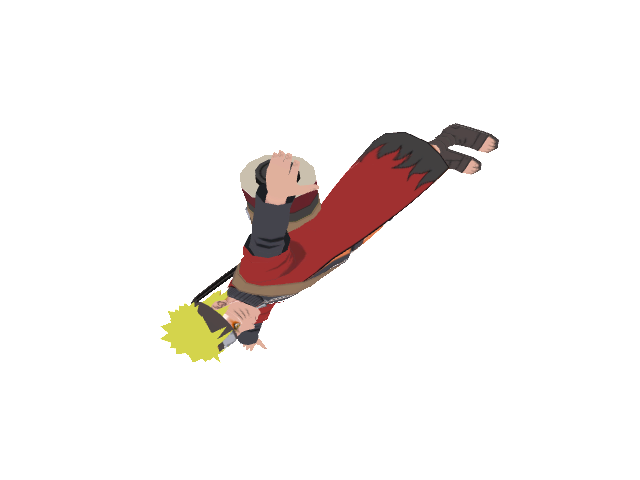

In [4]:
image, pose, mask = scene.sample()
image

## Generating Visual Hull

In [10]:
import time
import numpy as np
from tqdm import tqdm

resolutions = range(50, 301, 50)
execution_times = []

for reso in resolutions:
    start_time = time.time()
    # Camera parameters
    K = scene.intrinsics_matrix() 
    _fx = K[0, 0]
    _fy = K[1, 1]
    _cx = K[0, 2]
    _cy = K[1, 2]
    
    # Camera position and object bounds
    cam_pos = np.array([0, 0, 2])
    bounds = np.array([
        [-0.810964,  0.001889, -0.810964],
        [ 0.810959,  1.7243  ,  0.810959]
    ])
    bounds[:, 1] -= 1 
    n_vxls = np.array([reso, reso, reso])
    volume = np.zeros(n_vxls, dtype=np.uint8)
    intensities = np.zeros((*list(n_vxls), 3), dtype=np.float16) 
    step = (bounds[1] - bounds[0]) / n_vxls  # Voxel size
    
    xi = np.arange(n_vxls[0])
    yi = np.arange(n_vxls[1])
    zi = np.arange(n_vxls[2])
    indices = np.stack(np.meshgrid(xi, yi, zi, indexing='ij'), axis=-1)
    
    # Compute voxel centers
    centers = bounds[0] + step / 2.0 + step * indices
    centers = centers.reshape(-1, 3)
    
    for image, pose, mask in tqdm(zip(images, poses, masks), total=len(images)):
        [x, y, z] = scene.T @ np.linalg.inv(pose[:3, :3]) @ centers.T + cam_pos[:, None]
        
        x_proj = (_cx + np.rint(x / z * _fx)).astype(np.int32)
        y_proj = (_cy + np.rint(y / z * _fy)).astype(np.int32)
        
        H, W = mask.shape
        valid = (x_proj >= 0) & (x_proj < W) & (y_proj >= 0) & (y_proj < H)
        x_proj = np.clip(x_proj, 0, W - 1)
        y_proj = np.clip(y_proj, 0, H - 1)
        
        valid_voxels = (valid & (mask[y_proj, x_proj] > 0)).reshape(n_vxls)
        voxel_indices = indices[valid_voxels]
        
        x_idx, y_idx, z_idx = voxel_indices.T
        volume[x_idx, y_idx, z_idx] += 1
        I = (np.array(image)[y_proj, x_proj].astype(np.float16) * valid.astype(np.float16)[:, None]).reshape((*list(n_vxls), 3))
        intensities += I

    intensities /= len(images)
    intensities = np.clip(np.rint(intensities), a_min=0, a_max=255).astype(int)
    
    # Considering the object mask to be made of voxels that are present in all the images
    obj_mask = volume >= len(images)
    
    # Storing the voxels in the object mask with their corresponding colour and writing it to a JSON file 
    data = {
        "version": "Voxel Builder 4.5.1",
        "project": {
            "name": "naruto",
            "voxels": int(np.sum(obj_mask))
        },
        "data": {
            "voxels": ";".join([f"{v[0]},{v[1]},{v[2]},{rgb_to_hex(v)},1" for v in zip(*np.where(obj_mask))])
        }
    }
    with open('model.json', 'w') as fp:
        json.dump(data, fp)
    execution_times.append(time.time() - start_time)
# Output results
print("Execution times for various resolutions:", execution_times)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:13<00:00,  3.66s/it]


Execution times for various resolutions: [0.3715634346008301, 2.8657150268554688, 9.680560111999512, 23.389015913009644, 45.763044357299805, 78.67292356491089]


## Shading the Object

In [6]:
# Initialize a 4-channel (RGB + count) intensity array for each voxel
intensities = np.zeros((*list(n_vxls), 4), dtype=np.float32)

# Iterate over images, camera poses, and masks for each view
for image, pose, mask in tqdm(zip(images, poses, masks), total=len(images)):
    # Convert the image and mask to float32 format
    image = np.array(image).astype(np.float32)
    mask = np.array(mask)
    
    # Segment out the mask where there is a detected surface
    seg = np.where(mask > 0)
    y, x = seg[0], seg[1]

    # Project the segmented points from image plane to 3D space
    dx = (x.astype(np.float32) - _cx) / _fx
    dy = (y.astype(np.float32) - _cy) / _fy
    dz = np.ones_like(dx, dtype=np.float32)

    # Create 3D rays for each point in the segment
    rays = (pose[:3, :3] @ scene.T @ np.vstack((dx, dy, dz))).T
    casting = np.ones(len(dx), dtype=bool)  # Initialize casting mask to track active rays

    # Iterate through each depth level along the rays
    for z in np.arange(1000) * step.min() / 2:
        # Calculate 3D points along the rays based on depth `z`
        points = pose[:3, :3] @ cam_pos + rays * z

        # Convert 3D points to voxel grid coordinates
        voxel_coords = np.floor((points - bounds[0]) / step).astype(int)

        # Determine valid voxel coordinates within the grid bounds
        valid_mask = ((voxel_coords >= 0) & (voxel_coords < n_vxls)).all(axis=1)
        valid_voxels = voxel_coords[valid_mask]
        valid_indices = np.where(valid_mask)[0]

        # Skip if no valid voxels are found
        if len(valid_voxels) == 0:
            continue

        # Check if the voxel is part of the object's surface
        surface_voxels = volume[valid_voxels[:, 0], valid_voxels[:, 1], valid_voxels[:, 2]] >= len(images)
        surf_voxel_indices = valid_indices[surface_voxels]

        # Accumulate colors for each detected surface voxel
        if len(surf_voxel_indices) > 0:
            sv_coords = valid_voxels[surface_voxels]
            colors = image[y[surf_voxel_indices], x[surf_voxel_indices]]
            for idx, coord in enumerate(sv_coords):
                i, j, k = coord
                intensities[i, j, k, :3] += colors[idx]   # Add color to intensity array
                intensities[i, j, k, 3] += 1              # Increment the count

        # Update casting mask to disable rays that hit the surface
        casting[valid_indices] &= ~surface_voxels
        if not casting.any():
            break  # Exit loop if all rays have hit the surface

# Normalize RGB intensities by dividing by the count
non_zero_counts = intensities[..., 3] > 0
intensities[non_zero_counts, :3] /= intensities[non_zero_counts, 3, None]

# Clip values to [0, 255] and round them, preparing for visualization
intensities = np.clip(np.rint(intensities[:, :, :, :3]), a_min=0, a_max=255).astype(int)

# Create an object mask based on filled voxel data
obj_mask = volume >= len(images)

# Prepare the voxel data for JSON output
data = {
    "version": "Voxel Builder 4.5.1",
    "project": {
        "name": "naruto",
        "voxels": int(np.sum(obj_mask))
    },
    "data": {
        "voxels": ";".join([f"{v[0]},{v[1]},{v[2]},{rgb_to_hex(intensities[v[0], v[1], v[2]])},1" for v in zip(*np.where(obj_mask))])
    }
}

# Save the data as JSON in 'model.json'
with open('model.json', 'w') as fp:
    json.dump(data, fp)

NameError: name 'n_vxls' is not defined